# LLM Data Pipeline: Tokenization & Sliding Windows

**Purpose:** This notebook demonstrates how to tokenize a raw text file with `tiktoken`, build a sliding-window `Dataset` for autoregressive training, and create small batches for inspection. All code cells remain unchanged — only markdown and explanations were improved for clarity.

---

### Overview

* **Tokenization** — use `tiktoken` (GPT-2 BPE) to convert text to token IDs.
* **Sliding window dataset** — produce overlapping input/target chunks for autoregressive training.
* **Batching & embeddings** — create `DataLoader` batches and map tokens to dense vectors.

### Requirements

* `Data.txt` (a UTF-8 text file) in the same directory as the notebook.
* `tiktoken` Python package (install with `pip install tiktoken`).
* `PyTorch` available for `Dataset`, `DataLoader`, and tensors.

### Table of contents

1.  Setup and Installation
2.  Data Loading & Tokenization
3.  Quick tokenization check
4.  Causal Modeling — input/target shift
5.  Growing-context illustration
6.  Sliding-window Dataset: idea & implementation
7.  DataLoader factory
8.  Sanity checks (reload & sample batches)
9.  Token embeddings and shapes
10. Create a small embedded batch (example)
11. Embed inputs into 256-dimension vectors
12. Notes & next steps

## 1. Setup and Installation
Install the required tokenizer package if you haven't already:

In [1]:
pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


## 2. Data Loading & Tokenization
Read the source text and initialize the tokenizer. The following code reads `Data.txt` into `raw_text` and prepares `tiktoken` (GPT-2 encoding).

In [2]:
import tiktoken
with open("Data.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

## 3. Quick tokenization check
This short block prints the first character of the file, tokenizes with the **GPT-2 BPE encoder** and shows the token count and a short token sample.


In [3]:
print(raw_text[:1])
tokenizer = tiktoken.get_encoding('gpt2')
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))
enc_sample = enc_text[:50]

I
10870


## 4. Causal Modeling — input/target shift (x, y example)
**Autoregressive models** predict the next token given a context. Below we create `x` as a context of `context_size` tokens and `y` as the next token sequence (shifted by one, which is the model's target).


In [4]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:     {y}")

x: [40, 367, 2885, 1464]
y:     [367, 2885, 1464, 1807]


## 5. Growing-context illustration (what the model sees)
This loop demonstrates how the context grows token-by-token and the desired next token at each step. This visualizes the fundamental prediction task of the model.

In [5]:
for i in range (1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(f"in interation {i}, with : {tokenizer.decode(context)} ==> : {tokenizer.decode([desired])}")

in interation 1, with : I ==> :  H
in interation 2, with : I H ==> : AD
in interation 3, with : I HAD ==> :  always
in interation 4, with : I HAD always ==> :  thought


## 6. Sliding-window Dataset: idea & implementation
**Idea:** From a single long token sequence, we produce many overlapping input/target examples.
* For a `max_length` window, we take tokens `[i:i+max_length]` as **input**.
* We take tokens `[i+1:i+max_length+1]` as the **target**.
* The **stride** controls the amount of overlap between consecutive samples.

**Why:** This approach maximizes training data utilization and ensures each token appears in several contexts. 

**Implementation (unchanged)** — this class produces `(input_ids, target_ids)` samples.

In [6]:
from torch.utils.data import Dataset, DataLoader
class GPTDataSetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1: i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk)) 

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]


## 7. DataLoader factory
The helper function below constructs the `GPTDataSetV1` and wraps it in a PyTorch `DataLoader`. This allows for efficient batching and multi-processing (controlled by `num_workers`). This cell remains unchanged.

In [7]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=6):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataSetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

## 8. Sanity checks (reload & sample batches)
We reload the text (optional but kept for flow) and sample a couple of batches with a small `stride=1` and `max_length=4`. This clearly validates that the windowing and batching behave as expected.

In [8]:
with open("Data.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [9]:
import torch
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)

data_iter = iter(dataloader)
first_batch = next(data_iter)
second_batch = next(data_iter)
print("First Iter : ", first_batch)
print("Second Iter : ", second_batch)

First Iter :  [tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
Second Iter :  [tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


## 9. Token embedding layer (shapes)
We create a **token embedding layer** (`nn.Embedding`) to map the integer token IDs to dense, continuous vectors. This is the first step of the Transformer input process. Positional embeddings are typically added after this step.


In [10]:
vocab_size= 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

# Shape note: If inputs has shape (B, T) then token_embedding_layer(inputs) => (B, T, output_dim).

## 10. Create a small embedded batch (example)
We instantiate a dataloader with a `batch_size=8` and `max_length=4`. The input tensor will have shape $(8, 4)$, which then gets embedded to $(8, 4, 256)$ when passed through `token_embedding_layer`.

In [11]:
max_length =4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)

data_iter = iter(dataloader)
inputs,targets = next(data_iter)
#for i in range(5):
 #   print("\nInput tokens : \n", tokenizer.decode(inputs[i].tolist()))
    #print("\n Inputs Shape: \n", inputs.shape)\
    
  #  print("\n Targets tokens : \n", tokenizer.decode(targets[i].tolist()))
    #print("\n Targets Shape: \n", targets.shape)

## 11. Embed inputs into 256-dimension vectors
The step to convert the token IDs to their dense vector representation, ready for the Transformer blocks.

In [12]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


## 12. Create another embedding layer for the postional encoder

Add positional embeddings and implement the self-attention mechanism + transformer blocks to build a full model.


In [13]:
context_size = max_length
pos_embedding_layer = torch.nn.Embedding(context_size, output_dim)

In [14]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


## 12. Implementation of a placeholder gpt model

Just a dummy class with placeholders


In [15]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

Behold the dummy class

In [16]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.

        return x

## GPT ARCHITECTURE PART 2: **The Layer Normalization Part**

The layer normalization in the GPT architecture is crucial for two primary reasons:

1.  **To mitigate vanishing or exploding gradients**, making the training process more stable.
2.  **To reduce Internal Covariate Shift**, which refers to the problem of input distributions changing within the neural network layers during training.

***

The normalized values are adjusted to have a mean of zero and a variance of one.

$$
\text{formula} = \frac{(\text{layer} - \text{mean\_of\_layer})}{\sqrt{\text{variance\_of\_layer}}}
$$

***

In [17]:
#Example
import torch, torch.nn as nn
torch.manual_seed(123)
batch_example = torch.rand(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU()) # Relu for positive values onlly
out = layer(batch_example)
print("Out : \n", out)
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean : \n ", mean)
print("Variance : \n ", var)
out_norm = (out - mean)/ torch.sqrt(var)
print("Normalized layer outputs : \n", out_norm)
mean_norm = out_norm.mean(dim=-1, keepdim=True)
var_norm = out_norm.var(dim=-1, keepdim=True)
print("Normalized Layers Mean: \n", mean_norm)
print("Normalized Laters Variance \n", var_norm)

Out : 
 tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean : 
  tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance : 
  tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)
Normalized layer outputs : 
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Normalized Layers Mean: 
 tensor([[ 5.9605e-08],
        [-4.9671e-08]], grad_fn=<MeanBackward1>)
Normalized Laters Variance 
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


Layer normalizatoin as a class. The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task. 

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

In [18]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [19]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[ 2.3842e-08],
        [-9.5367e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-success">

As we can see based on the results, the layer normalization code works as expected and
normalizes the values of each of the two inputs such that they have a mean of 0 and a
variance of 1:
</div>

## GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

The ReLu activation function is used to introduce non-linearility to the linear layers of the network, and to reduce the issue of the vanishing gradient problems. The ReLu sets all negative numbers to zero, which results in a zero gradient. If a neuron keeps on receiving negative inputs it can become permanently inactive or stop learning resulting in a Dead Neuron. The GeLu can allow small negative values to pass through it , and its also differentiable at every point, since it has a curvature.

Calculating the Gaussian CDF is computationally expensive, so there is a close approximation :

$$GELU(x) \approx 0.5x \left( 1 + \tanh \left( \sqrt{\frac{2}{\pi}} (x + 0.044715x^3) \right) \right)$$


In [20]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):   # GeLu is the CDF of the standard guassian distribution
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

PLOT GELU VS RELU:

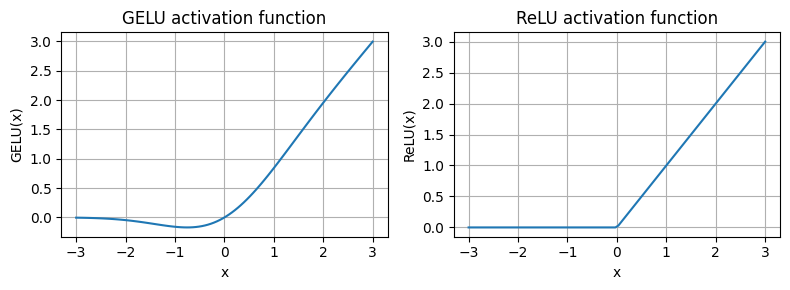

In [21]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


Using the GELU class in a small FeedForward network, which will be used in the transformer block later:

In [22]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)

In [23]:
print(GPT_CONFIG_124M["emb_dim"])


768


The Feedforward Module, helps the model be able to learn and generalize the data. The input and output dimensions of this network is the same, it expands the embedding dimension into a higher dimensional space for a rich representation exploration. Also the uniformity of the input and output dimensions enables the stacking of layers which makes the model scalable.

In [24]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## GPT ARCHITECTURE PART 4: **Shortcut Connections**

Vanishing gradients are a problem so that weights dont get updated which halts the learning process. Shortcut connections create an alternate path for the gradient to flow, skipping one or more layers. This is achieved by adding the output of one layer to the output of a latter layer. Also reduces the chances of local minimums occuring in the loss surface.

In [25]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1], GELU)),
                nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2], GELU)),
                nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3], GELU)),
                nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4], GELU)),
                nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5], GELU)),
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            # ts the place where shorti cuti
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
            
        return x 

For now initialize the neural network without shortcut connection

In [26]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
with_out = ExampleDeepNeuralNetwork(layer_sizes, False)

In [27]:
def print_gradient(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight'  in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In code above, there is a loss function that computes how close the output of the model is close to the one specified by the user. loss.backward() , this computes the loss gradient for each layer in the model

In [28]:
print_gradient(with_out, sample_input)

layers.0.0.weight has gradient mean of 0.001531339017674327
layers.1.0.weight has gradient mean of 0.0008734675939194858
layers.2.0.weight has gradient mean of 0.0021116069983690977
layers.3.0.weight has gradient mean of 0.0030934528913348913
layers.4.0.weight has gradient mean of 0.00788064580410719


In [29]:
torch.manual_seed(123)
model_with = ExampleDeepNeuralNetwork(layer_sizes, True)
print_gradient(model_with, sample_input)

layers.0.0.weight has gradient mean of 0.2261722832918167
layers.1.0.weight has gradient mean of 0.5056600570678711
layers.2.0.weight has gradient mean of 0.30353114008903503
layers.3.0.weight has gradient mean of 0.454271525144577
layers.4.0.weight has gradient mean of 0.9717203974723816


When using a shortcut connection, it can be seen that instead of the weights vanishing as it approaches the layer 0, it stabilizes.

## GPT ARCHITECTURE PART 5: **The Attention and Linear Block**

In [30]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

Layer Normalization, GeLu and Feed-Forward NN

In [31]:
import torch
import torch.nn as nn

In [32]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
 

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x ): # GeLu is the CDF of the standard guassian distribution
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)


The Multi-Head attention Class from the Attention Mechanisms notebook

In [33]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.out_proj = nn.Linear(d_out, d_out)  
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) 
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3) 

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        
        return self.out_proj(context_vec)

Lets be coding on the **Transformer Block**

<div align="center">
    <img src="image_26d267.png" width="400px">
    <p>
        <b>Figure 1: Transformer Block Architecture</b><br>
        A single transformer layer showing the <b>Masked Multi-Head Attention</b> and 
        <b>Feed-Forward</b> sub-layers. Each sub-layer is wrapped in a 
        <b>Residual Connection</b> followed by <b>Layer Normalization</b>. 
        The Feed-Forward block uses a <b>GELU</b> activation between two linear layers 
        to process the (2, 4, 768) tensor.
    </p>
</div>

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # x has a shape of [ batch_size, num_tokens, emb_size]
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x 

Instantiateeeee the transformer finally.....

In [35]:
torch.manual_seed(123)
x = torch.rand(2, 4 , 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape: ", x.shape)
print("Output shape : ", output.shape)

Input shape:  torch.Size([2, 4, 768])
Output shape :  torch.Size([2, 4, 768])


this be showing that the dimension of the inputs and outputs are identical, this is important for shortcut(residual) connections, and also the output is rich with context and representation.

## GPT ARCHITECTURE PART 6: **The enture gpt model architecture implementation**

In [36]:
import torch, torch.nn as nn 

In [37]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [38]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential( *[TransformerBlock(cfg) for _ in range (cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds+ pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x) # the logits of the possible vocabs
        return logits

Init a the 124 milli parameter model using the gpt config and pass an input with 2 batches and 4 tokens

In [39]:
torch.manual_seed(123)
batch = torch.tensor([[6109, 3626, 6100, 345], [6109, 1110, 6222, 257]])
model = GPTModel(GPT_CONFIG_124M)
output = model(batch)
print("Input : \n", batch)
print("Output shape : ", output.shape)
print("Output : \n", output)

Input : 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6222,  257]])
Output shape :  torch.Size([2, 4, 50257])
Output : 
 tensor([[[ 0.5289,  0.5610, -0.1104,  ...,  0.2982,  0.3101, -0.5219],
         [ 0.2358, -0.4771, -0.6717,  ..., -0.0187,  0.5173, -0.4534],
         [ 0.7834,  0.1488, -0.0547,  ..., -0.0469, -0.2584, -0.1415],
         [-0.8937,  0.5101, -0.1395,  ...,  0.7612,  0.2748, -0.2165]],

        [[-0.0082,  0.2622, -0.2779,  ...,  0.7838,  0.2923, -0.7756],
         [ 0.1727,  0.1146,  0.0530,  ...,  0.9633,  0.1950,  0.3541],
         [ 0.9895,  0.9686,  0.0646,  ..., -0.1545, -0.5203, -0.1120],
         [ 0.2321,  0.0946,  0.4965,  ...,  1.1556, -0.1386, -0.0570]]],
       grad_fn=<UnsafeViewBackward0>)


As seen the output has 2 batches , with 4 tokens with the vocab size of 50257 as the possible logits

**Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors:**

In [40]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


This number of paramters is higher than the expected 124M paramters, this is because in the GPT2 architecture, the paramters used for the token embedding layer where the same ones used in the linear output layer that is why it is less.

In [41]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


Both these weights have the sane shape, so if we remove this paramter count from the total and get 124 million

In [42]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


This reduces memory usage and computation cost of the model. It is said that using separate weights leads to better results and model performance

the memory requirements of the 163 million parameters in GPTModel object: ( assuming that using float32 weights which is 4 bytes)

In [43]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## GPT ARCHITECTURE PART 7: **Getting the text from the output of the GPT model**

So basically the input(idx) is of shape batch, number of tokens which is the current context. Crop the current context(input), exceeds the supported context size. There is also a specified amount of maximum amount of newly generated tokens by the model. We take the output of the last token array, apply a softmax function to get it as a tensor of probailities and pick the index of the largest one and that will be the token id of the predicted word. Here the loss function wasnt measured, and the model isn't trained, just to demonstrate how the text is generated after the output of the GPT class/model

In [44]:
def gen_text_v1(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad(): # ts disables the autrograd engine , used for inference here so weights dont accidently be changing
            logits = model(idx_cond)
        
        logits = logits[:, -1, :] # ts takes the last time step/row from each batch [ batch, n_tokens, vocab_size]
        probab = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probab, dim=-1, keepdim=True) # argmax returns the index of the one with the largest value
        idx = torch.cat((idx, idx_next), dim=1) # cat concatenates tensors across a specified dimension
    
    return idx

For now softax is kind of redundant, could literally just put logits in argmax but later on it is useful to use sampling techniques suxh that the model doesnt pick most likely token which brings variability and creativity in the output text.

Generating text in the untrained model:

In [45]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
init_context = "The window was "
encoded = tokenizer.encode(init_context)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # unsqueeze to add dim to be a batch
print("Encoded Tensor : \n", encoded_tensor)

Encoded Tensor : 
 tensor([[ 464, 4324,  373,  220]])


Since this is just inference and not training do model.eval() which bypasses dropout and normalization.

In [46]:
model.eval()
out = gen_text_v1(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output : ", out)
print("Decoded Output : \n ", tokenizer.decode(out.squeeze(0).tolist()))

Output :  tensor([[  464,  4324,   373,   220, 41323,  9866, 22210,  2563, 17294, 28964]])
Decoded Output : 
  The window was  dmgmasterSomething drugificant devised


# Reduce the context size to 256 because my pc is potatoe is helps with training # 

In [ ]:
import torch, torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

define two new functions to convert text to token ids and vice versa for the input and output encoding and decoding

In [48]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Living with linux for"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = gen_text_v1(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("output text: \n", token_ids_to_text(token_ids, tokenizer))

output text: 
 Living with linux for Totally Cooperxualwed negativityyersumin meeting� Have


As seen the model doesnt actually generate good text becuase it hasn't been trained yet. To understand what a good text is we have to define a loss function. This is done by comparing the predicted values and the target values. The targets are the inputs shifted by one.

In [49]:
inputs = torch.tensor([[16833, 3626, 6100], # every effort moves
                        [40, 1107, 588]])   # I really like

targets = torch.tensor([[3626, 6100, 345], #  effort moves you
                        [1107, 588, 11311]])   #  really like chocolate

with torch.no_grad():
    logits = model(inputs)

probabs = torch.softmax(logits, dim=-1)
print(probabs.shape)

token_ids = torch.argmax(logits, dim=-1, keepdim=True)
print("Token IDS : \n", token_ids)

torch.Size([2, 3, 50257])
Token IDS : 
 tensor([[[38862],
         [43027],
         [ 8569]],

        [[42085],
         [31970],
         [16774]]])


If we decode the target and the predicted output, there is a discrepency because the model isnt trained yet

In [50]:
print(f"Targets in batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs in batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets in batch 1:  effort moves you
Outputs in batch 1:  doverank comprehens


**Cross Entropy Loss**
1. The "Log" is a Math Rescue: We can't just multiply probabilities because they get tiny ($0.0001 \times 0.0001 \dots$) and eventually turn into zero in computer memory (underflow). By taking the Log, we can add the scores instead of multiplying them. It keeps the math stable.2. The "Penalty" Scale: The Log acts as a magnifying glass for being wrong.If the model gives the right word a 90% chance, the loss is tiny.If it gives it a 0.01% chance, the Log makes the loss massive.It forces the model to "feel" the pain of its mistakes so it learns faster.3. Why the Batch Mean? We average the loss across the whole batch (e.g., 32 sentences) so the "signal" stays consistent. If we used the Sum, the loss would get 10x bigger just because we used a bigger batch, which would break the training. The Mean tells us the average "amount of error" per token.

In [51]:
text_idx = 0
targets_probas_1 = probabs[text_idx, [0,1,2], targets[text_idx]]
print("Target Probabs for text 1 : ", targets_probas_1) 
text_idx = 1
targets_probas_2 = probabs[text_idx, [0,1,2], targets[text_idx]]
print("Target Probabs for text 2 : ", targets_probas_1)

log_probabs = torch.log(torch.cat((targets_probas_1, targets_probas_2)))
print(log_probabs)
avg_log_probabs =  torch.mean(log_probabs)
print(avg_log_probabs)

Target Probabs for text 1 :  tensor([3.3706e-05, 2.9752e-05, 1.4406e-05])
Target Probabs for text 2 :  tensor([3.3706e-05, 2.9752e-05, 1.4406e-05])
tensor([-10.2978, -10.4226, -11.1479, -10.7451, -10.9641, -10.9539])
tensor(-10.7552)


If the positive of the avg log is it that would mean maximazing the loss function, so we go the opposite and take the negative of the log

In [52]:
neg_avg_log_probabs = avg_log_probabs * -1
print(neg_avg_log_probabs)

tensor(10.7552)


For the cross entropy function in pytorch we need to flatten the tensors by combining them over the batches.

In [53]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print("Flattened logits : ", logits_flat.shape)
print("Flattened targets : ", targets.shape)

Flattened logits :  torch.Size([6, 50257])
Flattened targets :  torch.Size([2, 3])


In PyTorch, we don't usually calculate Softmax and Log-Loss separately. Instead, we use torch.nn.functional.cross_entropy(logits, targets). This function does three things at once:

Log-Softmax: It converts the raw logits into log-probabilities.

NLL Loss (Negative Log Likelihood): It plucks out the score for the correct word (the slicing we just did) and applies the penalty.

Averaging: It calculates the mean loss across the entire batch.

In [54]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross Entropy Loss: ", loss)

Cross Entropy Loss:  tensor(10.7552)


### **Perplexity: Measuring Model "Confusion"**

Perplexity is mathematically the exponent of the Cross Entropy Loss:
$$\text{Perplexity} = e^{\text{Loss}}$$

**What it tells us:**
It represents the **"effective number of choices"** the model is picking from at any given time.
* **Perplexity = 50,257:** (Vocab size) The model is guessing completely randomly.
* **Perplexity = 10:** The model is as "confused" as if it had to choose between 10 equally likely words.
* **Perplexity = 1:** The model is perfectly certain and 100% correct.

**Why use it?**
Loss (e.g., 2.3) is for the computer's backpropagation. Perplexity is for humans—it's much easier to visualize the model narrowing its "search space" from 100 words down to 5 words.

So in this current state it has a koss of 10.7 roughly tht means the model is roughly as uncertain as if it had to choose the next token randomly from about 48725 tokens in the vocabulary.

### **Evaluating Loss on a real example dataset**

The reality is that it takes an immenese amount of data to train models. This is a very small dataset that can run the code in this notebool in a computer without a gpu. Using a chapter of the Book The Verdict by Edith Wharton.

In [55]:
import os
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
file_path = "Data.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
print(text_data[:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [56]:
print("Total number of characters : ", len(text_data))
print("Total number of tokens ", len(tokenizer.encode(text_data)))

Total number of characters :  48930
Total number of tokens  10870


This number of tokens is quite too small, but I dont got a cool half a mil to spend on GPUs

### Now divide the data into training and test set, use the dataset and dataloader

In [57]:
from torch.utils.data import Dataset, DataLoader
class GPTDataSetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1: i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk)) 

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

        

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=6):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataSetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [58]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    num_workers=0
)


Some checks so that the training dont break

In [59]:
total_tokens = len(tokenizer.encode(text_data))
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for trianing")
if total_tokens * (1- train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for validation")


Seeing the shapes of the data :

In [60]:
print("Training Loader : ")
for x , y in train_loader:
    print(x.shape, y.shape)

print("\nVaalidation Loader : ")
for x , y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Training Loader : 
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 

### **Getting LLM outputs on Dataset**

Write a function to calculate the cross entropy loss, taking in the input batch and the target batch. Pass the input batch into the model and get the logits, then flatten the logits. Also a function that calculates all the losses from all the batches

In [61]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches
    

Use torch device to run on a CUDA ready GPu or CPU, which ever one is available.

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training Loss : ", train_loss)
print("Validation Loss : ", val_loss)

Training Loss :  11.001119974497202
Validation Loss :  10.972976446151733


## Setting up the training loop

- **Initialization**:
  - Define and initialize lists for storing training losses, validation 
losses, and track tokens seen.
  - Initialize variables to keep track of tokens seen and global steps.

```python
# Initialization
train_losses, val_losses, track_tokens_seen = [], [], []
tokens_seen, global_step = 0, -1
```

- **Epoch Loop**:
  - Set the model to training mode using `model.train()`.

```python
for epoch in range(num_epochs):
    model.train()
```

- **Batch Loop**:
  - Iterate over each input batch and target batch from the 
`train_loader`.

```python
for input_batch, target_batch in train_loader:
```

- **Gradient Reset**:
  - Clear the gradients of all model parameters using 
`optimizer.zero_grad()`.
  - This ensures that gradients are not accumulated across iterations.

```python
    optimizer.zero_grad()
```

- **Loss Calculation**:
  - Compute the loss for the current batch using the `calc_loss_batch` 
function, passing the input and target batches along with the model and 
device.

```python
    loss = calc_loss_batch(input_batch, target_batch, model, device)
```

- **Backward Pass**:
  - Perform backpropagation by calling `loss.backward()`, which computes 
the gradients of the loss function with respect to all model parameters.

```python
    loss.backward()
```

- **Parameter Update**:
  - Apply the computed gradients to update the model's parameters using 
`optimizer.step()`.
  - This updates each parameter based on its gradient and the optimizer's 
learning rate.

```python
    optimizer.step()
```

- **Tokens Seen Tracking**:
  - Calculate the number of tokens seen in the current batch using 
`input_batch.numel()` and add it to `tokens_seen`.

```python
    tokens_seen += input_batch.numel()
    global_step += 1
```

- **Evaluation Period**:
  - Check if the current global step is a multiple of `eval_freq`.
  - If so, evaluate the model on both the training and validation datasets 
using the `evaluate_model` function.
  - Append the computed training and validation losses to their respective 
lists (`train_losses` and `val_losses`).
  - Update the list `track_tokens_seen` with the current number of tokens 
seen.

In [63]:
def train_model_v1(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen , global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
   
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # ts resets the gradient for each iteration so it dont accumulate
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step() # ts sets the update of the parameters
            tokens_seen += input_batch.numel()
            global_step +=1

            if global_step % eval_freq == 0:
                train_loss, val_loss = eval_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch:  {epoch}, [step {global_step:06d}]: "
                f"Traning loss: {train_loss:.3f}, Valdation loss:{val_loss:.3f} ")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [64]:
def eval_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss =  calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [65]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = gen_text_v1(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [66]:
def gen_text_v1(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad(): # ts disables the autrograd engine , used for inference here so weights dont accidently be changing
            logits = model(idx_cond)
        
        logits = logits[:, -1, :] # ts takes the last time step/row from each batch [ batch, n_tokens, vocab_size]
        probab = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probab, dim=-1, keepdim=True) # argmax returns the index of the one with the largest value
        idx = torch.cat((idx, idx_next), dim=1) # cat concatenates tensors across a specified dimension
    
    return idx

**Train the Model for 15 epochs using the AdamW Optimizer**

In [67]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_v1(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context="I hate it when", tokenizer=tokenizer
)

end_time = time.time()
execution_time_in_mins = (end_time - start_time) / 60
print(f"Traning Compleed in {execution_time_in_mins:2f} minutes")

Epoch:  0, [step 000000]: Traning loss: 9.729, Valdation loss:10.240 
Epoch:  0, [step 000005]: Traning loss: 8.887, Valdation loss:9.284 
Epoch:  0, [step 000010]: Traning loss: 7.783, Valdation loss:8.678 
Epoch:  0, [step 000015]: Traning loss: 6.966, Valdation loss:8.720 
Epoch:  0, [step 000020]: Traning loss: 7.054, Valdation loss:8.801 
Epoch:  0, [step 000025]: Traning loss: 6.954, Valdation loss:8.852 
Epoch:  0, [step 000030]: Traning loss: 6.693, Valdation loss:8.704 
Epoch:  0, [step 000035]: Traning loss: 6.509, Valdation loss:8.647 
I hate it when, and                                                
Epoch:  1, [step 000040]: Traning loss: 6.389, Valdation loss:8.635 
Epoch:  1, [step 000045]: Traning loss: 6.114, Valdation loss:8.686 
Epoch:  1, [step 000050]: Traning loss: 6.065, Valdation loss:8.759 
Epoch:  1, [step 000055]: Traning loss: 6.013, Valdation loss:8.830 
Epoch:  1, [step 000060]: Traning loss: 6.031, Valdation loss:8.903 
Epoch:  1, [step 000065]: Traning 

In [74]:
prompt = "sugar"
idx = text_to_token_ids(prompt, tokenizer)
response_tok_id = gen_text_v1(model, idx, 20, 1024)
response = token_ids_to_text(response_tok_id, tokenizer)
print(response)

sugar had the place of honour--say the central panel in a pale yellow or _rose Dubarry_
